In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


### Load data

In [2]:
pd.set_option("display.max_columns", None)
data_dir = Path.cwd().parent / "data"

In [3]:
# 1. CRSP–Compustat
crsp_compustat = pd.read_csv(
    data_dir / "crsp_compustat_raw.csv",
    parse_dates=["datadate", "MthCalDt"],
)

# Handle data
crsp_compustat["YYYYMM"] = pd.to_datetime(
    crsp_compustat["YYYYMM"], format="%Y%m"
).dt.to_period("M")
crsp_compustat["cal_year"] = crsp_compustat["MthCalDt"].dt.year
crsp_compustat["PERMNO"] = crsp_compustat["PERMNO"].astype("Int64")

# Keep only data on CRSP
crsp_compustat = crsp_compustat[crsp_compustat["PERMNO"].notna()]

# Keep only one entry per fiscal year, keeping the latest one
crsp_compustat = crsp_compustat.sort_values(
    ["PERMNO", "fyear", "datadate"]
).drop_duplicates(subset=["PERMNO", "fyear"], keep="last")

In [4]:
# 2. CRSP
crsp = pd.read_csv(
    data_dir / "crsp_raw.csv",
    parse_dates=["date"],
)

# Handle data
crsp["cal_year"] = crsp["date"].dt.year
crsp["PERMNO"] = crsp["PERMNO"].astype("Int64")
crsp["RET"] = pd.to_numeric(crsp["RET"], errors="coerce")

# Sort for all downstream rolling ops
crsp = crsp.sort_values(["PERMNO", "date"])


def geo_mean_return(x: pd.Series):
    # Drop NaNs, require at least one obs
    x = x.dropna()
    if len(x) == 0:
        return np.nan
    return (1.0 + x).prod() ** (1.0 / len(x)) - 1.0


annual_ret = (
    crsp.groupby(["PERMNO", "cal_year"])
    .agg(
        ret_arith=("RET", "mean"),
        ret_geo=("RET", geo_mean_return),
        n_months=("RET", "count"),  # useful sanity check
        SHRCD=("SHRCD", "first"),
        EXCHCD=("EXCHCD", "first"),
    )
    .reset_index()
)


def add_36m_vol(group: pd.DataFrame) -> pd.DataFrame:
    # Sort, put date as index
    g = group.sort_values("date").set_index("date")

    # Enforce a regular monthly index (month-end). Missing months become NaN rows.
    g = g.asfreq("ME")

    # Rolling over the last 36 monthly observations (36 calendar months)
    g["vol_36m"] = g["RET"].rolling(window=36, min_periods=12).std()

    return g.reset_index()


crsp_with_vol = crsp.groupby("PERMNO", group_keys=False).apply(add_36m_vol)
crsp_with_vol["cal_year"] = crsp_with_vol["date"].dt.year

# Pick the last month in each calendar year for each PERMNO
year_end_rows = (
    crsp_with_vol.sort_values(["PERMNO", "date"])
    .groupby(["PERMNO", "cal_year"])
    .tail(1)  # last monthly obs in that year
)

annual_vol = year_end_rows[["PERMNO", "cal_year", "vol_36m"]]

annual_crsp = annual_ret.merge(annual_vol, on=["PERMNO", "cal_year"], how="left")


C:\Users\chris\AppData\Local\Temp\ipykernel_40124\26881786.py:50: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  crsp_with_vol = crsp.groupby("PERMNO", group_keys=False).apply(add_36m_vol)


In [49]:
# 3. Merge
df = crsp_compustat.merge(
    annual_crsp,
    on=["PERMNO", "cal_year"],
    how="left",
)

df = df.sort_values(["PERMNO", "MthCalDt"])

### Factors

In [50]:
# Here we might want to consider fallbacks if these are not available
df["book_equity"] = df["ceq"] + df["txdb"] - df["pstk"]
mask = df["book_equity"].isna()
df.loc[mask, "book_equity"] = (
    df.loc[mask, "at"] - df.loc[mask, "lt"] + df.loc[mask, "pstk"] - df.loc[mask, "seq"]
)
mask = df["book_equity"].isna()
df.loc[mask, "book_equity"] = df.loc[mask, "at"] - df.loc[mask, "lt"]

# Value factor
df["value"] = df["MthCap"] / df["book_equity"]

# Profitability factor
df["oiadp"] = df["oibdp"] - df["dp"]
df["profitability"] = df["oiadp"] / df["book_equity"]

# Investing
df["prev_at"] = df.groupby("PERMNO")["at"].transform("last")
df["investment"] = df["prev_at"] / df["at"]

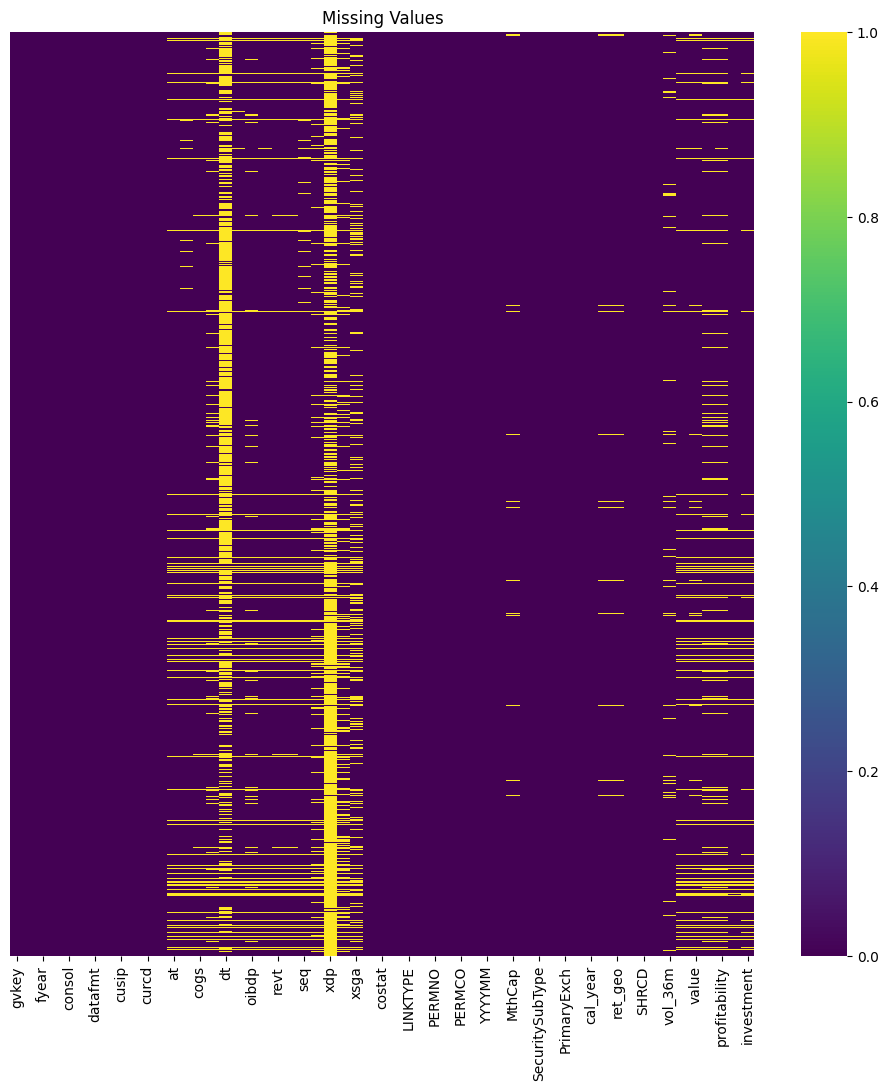

In [51]:
plt.figure(figsize=(12, 12))
sns.heatmap(df.isnull(), cbar=True, cmap="viridis", yticklabels=False)
plt.title("Missing Values")
plt.show()

### Stock universe filtering

In [52]:
# Filters:
df = df[df["SHRCD"].isin([10, 11])]  # common stock only
df = df[df["EXCHCD"].isin([1, 2, 3])]  # NYSE/AMEX/NASDAQ
df = df[(df["SICCD"] < 6000) | (df["SICCD"] > 6799)]  # no finance/insurance/REIT

# Now use a heuristic for finding big companies to only include, used to avoid survivorship-bias
# Assume we can use the MthCap per company, and that the timings align for comparing market capitalization

# NYSE only firms
nyse = df[df["EXCHCD"] == 1]

# Compute NYSE median each year
size_breakpoints = (
    nyse.groupby(nyse["MthCalDt"].dt.year)["MthCap"].median().rename("NYSE_Median")
)

df = df.merge(size_breakpoints, left_on=df["MthCalDt"].dt.year, right_index=True)

# Assign BIG / SMALL
df["SIZE"] = np.where(df["MthCap"] >= df["NYSE_Median"], "BIG", "SMALL")

# The paper keeps ONLY big stocks
df_big = df[df["SIZE"] == "BIG"].copy()

In [53]:
# Define target columns
cols_to_keep = [
    # identifiers
    "PERMNO",
    "gvkey",
    "tic",
    "cusip",
    "conm",
    # "YYYYMM",
    "MthCalDt",
    "SHRCD",
    "EXCHCD",
    # market data
    "ShrOut",
    "MthCap",
    "ret_arith",
    "ret_geo",
    "n_months",
    "vol_36m",
    # core balance sheet variables
    "value",
    "investment",
    "prev_at",
    "book_equity",
    "at",
    "ceq",
    "seq",
    "pstk",
    "lt",
    # profitability
    "profitability",
    "oibdp",
    "oiadp",
    "revt",
    "sale",
    # expenses
    "cogs",
    "dp",
    "xint",
    "xsga",
    # tax
    "txdb",
    "dt",
    # industry
    "sic",
    "SICCD",
]

df_big = df_big[cols_to_keep].copy()

# Rename for clarity
df_big = df_big.rename(
    columns={
        "MthCap": "market_cap",
        "MthCalDt": "date",
        "ShrOut": "n_shares",
        "at": "total_assets",
        "ceq": "common_equity",
        "seq": "shareholders_equity",
        "pstk": "preferred_stock",
        "lt": "total_liabilities",
        "oibdp": "oper_income",
        "revt": "revenue",
        "sale": "sales",
        "cogs": "cogs_expense",
        "dp": "depr_amort",
        "xint": "interest_expense",
        "xsga": "sga_expense",
        "txdb": "tax_deferred",
        "dt": "total_taxes",
    }
)


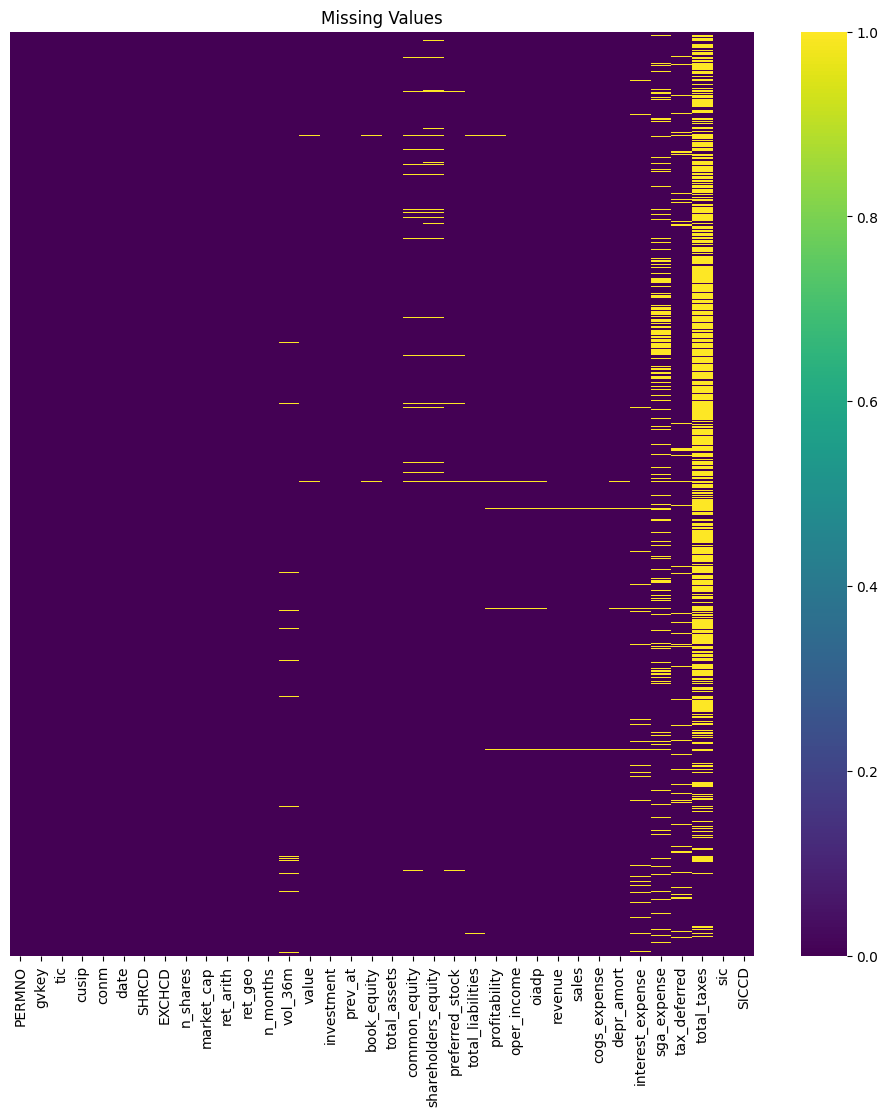

In [54]:
plt.figure(figsize=(12, 12))
sns.heatmap(df_big.isnull(), cbar=True, cmap="viridis", yticklabels=False)
plt.title("Missing Values")
plt.show()

In [58]:
df_big.to_csv("data_clean.csv", index=False)

In [57]:
final_cols = [
    "PERMNO",
    "date",
    "tic",
    "conm",
    "cusip",
    "market_cap",
    "n_shares",
    "n_months",
    "ret_arith",
    "ret_geo",
    "vol_36m",
    "value",
    "profitability",
    "investment",
]

df_factors = df_big[final_cols]
df_factors.to_csv("factors.csv", index=False)

In [ ]:
# compute VIF
# remove negative book equity?

### Factor returns

In [ ]:
import numpy as np
import pandas as pd

# 0. Basic prep
factor_df["date"] = pd.to_datetime(factor_df["date"])
factor_df = factor_df.sort_values(["date", "PERMNO"])

# Map short factor names (paper) to your signal columns
factor_cols = {
    "V": "value",  # value
    "W": "ret_geo",  # momentum signal
    "C": "investment",  # investment
    "R": "profitability",  # profitability
    "L": "vol_36m",  # low volatility
}

ret_col = "ret_arith"  # return used for portfolio performance
w_col = "market_cap"  # value weights


def value_weighted_return(group):
    """Value weighted return of ret_col using w_col within a group."""
    g = group.dropna(subset=[ret_col, w_col])
    if g.empty:
        return np.nan
    w = g[w_col]
    r = g[ret_col]
    w_sum = w.sum()
    if w_sum <= 0:
        return np.nan
    return (w * r).sum() / w_sum


def assign_terciles(x):
    """Assign 0 (bottom), 1 (middle), 2 (top) tercile based on ranks within a date."""
    n = x.notna().sum()
    if n < 3:
        return pd.Series(index=x.index, data=np.nan)
    ranks = x.rank(method="first")
    t1 = n / 3.0
    t2 = 2.0 * n / 3.0
    out = pd.Series(index=x.index, dtype="float")
    out[ranks <= t1] = 0
    out[(ranks > t1) & (ranks <= t2)] = 1
    out[ranks > t2] = 2
    return out


# 1. Build factor portfolio return series for each factor
factor_ret_list = []

for short_name, score_col in factor_cols.items():
    df = factor_df[["date", ret_col, w_col, score_col]].copy()
    df = df[~df[score_col].isna()]

    # Assign terciles per date on the factor signal
    df["tercile"] = df.groupby("date")[score_col].transform(assign_terciles)

    # Top and bottom terciles
    top = df[df["tercile"] == 2]
    bottom = df[df["tercile"] == 0]

    # Value weighted returns by date
    top_ret = (
        top.groupby("date").apply(value_weighted_return).rename(short_name + "_top")
    )

    bottom_ret = (
        bottom.groupby("date").apply(value_weighted_return).rename(short_name + "_bot")
    )

    # Factor return = top minus bottom
    fr = pd.concat([top_ret, bottom_ret], axis=1)
    fr[short_name] = fr[short_name + "_top"] - fr[short_name + "_bot"]

    # Keep only the factor return series
    factor_ret_list.append(fr[[short_name]])

# 2. Combine all factor return series into one dataframe
factor_returns = pd.concat(factor_ret_list, axis=1)
factor_returns = factor_returns.sort_index().dropna(how="any")

# factor_returns now has columns ["V", "W", "C", "R", "L"]
print(factor_returns.head())
